In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [4]:
df_application=pd.read_csv(r'F:\Dataset\Credit Card Approval\application_record.csv')

In [5]:
df_credit=pd.read_csv(r'F:\Dataset\Credit Card Approval\credit_record.csv')

In [7]:
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [41]:
21005/365

57.54794520547945

In [ ]:
df_credit.head()

In [6]:
print(df_application.shape,df_credit.shape)

(438557, 18) (1048575, 3)


In [6]:
df = df_application.merge(df_credit, how='inner', on=['ID']) #merging both the dataset

In [7]:
df.skew()

ID                  0.073626
CNT_CHILDREN        2.587310
AMT_INCOME_TOTAL    2.577642
DAYS_BIRTH         -0.176931
DAYS_EMPLOYED       1.808405
FLAG_MOBIL          0.000000
FLAG_WORK_PHONE     1.271030
FLAG_PHONE          0.867866
FLAG_EMAIL          2.830028
CNT_FAM_MEMBERS     1.324175
MONTHS_BALANCE     -0.598674
dtype: float64

In [15]:
df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

In [16]:
df.shape

(777715, 20)

### Split the data (to avoid data leakage)

In [7]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df,test_size=0.3,random_state=1)

In [8]:
x_train=df_train.drop('STATUS',axis=1)
y_train=df_train['STATUS']
x_test=df_test.drop('STATUS',axis=1)
y_test=df_test['STATUS']

# EDA

In [11]:
print(df_train.shape,df_test.shape)

(544400, 20) (233315, 20)


In [13]:
df_train['STATUS'].value_counts()

C    230751
0    203192
X    102361
1      6101
5      1093
2       554
3       198
4       150
Name: STATUS, dtype: int64

In [44]:
print(df_train['DAYS_BIRTH'].max()/365,df_train['DAYS_BIRTH'].min()/365)

-20.517808219178082 -68.90958904109588


In [47]:
df_train['DAYS_EMPLOYED'].max()

365243

In [12]:
print(df_train['DAYS_EMPLOYED'].max()/365,df_train['DAYS_EMPLOYED'].min()/365)
# DAYS_EMPLOYED=365243 means the person is unemployed. Lets convert it to 0

1000.6657534246575 -43.04931506849315


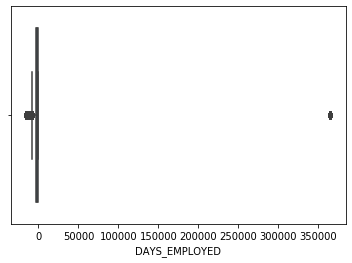

In [48]:
sns.boxplot(x='DAYS_EMPLOYED',data=df) # we have a pretty intense outlier here

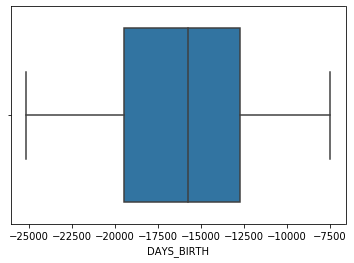

In [49]:
sns.boxplot(x='DAYS_BIRTH',data=df)

In [51]:
print(df_train['AMT_INCOME_TOTAL'].max(),df_train['AMT_INCOME_TOTAL'].min())

1575000.0 27000.0


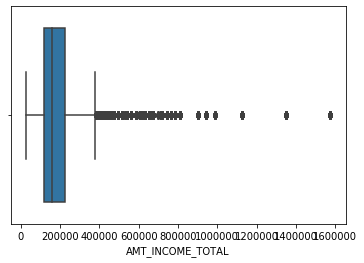

In [50]:
sns.boxplot(x='AMT_INCOME_TOTAL',data=df) 
# we mostly have outliers here (since the data has been duplicated,due to merging of df_credit the number of outliers are more)

In [13]:
df_train['STATUS'].value_counts()

C    230751
0    203192
X    102361
1      6101
5      1093
2       554
3       198
4       150
Name: STATUS, dtype: int64

In [19]:
df_train['NAME_FAMILY_STATUS'].value_counts()

Married                 382874
Single / not married     66000
Civil marriage           42169
Separated                31530
Widow                    21827
Name: NAME_FAMILY_STATUS, dtype: int64

In [20]:
df_train['NAME_HOUSING_TYPE'].value_counts()

House / apartment      488091
With parents            25041
Municipal apartment     17211
Rented apartment         7585
Office apartment         3894
Co-op apartment          2578
Name: NAME_HOUSING_TYPE, dtype: int64

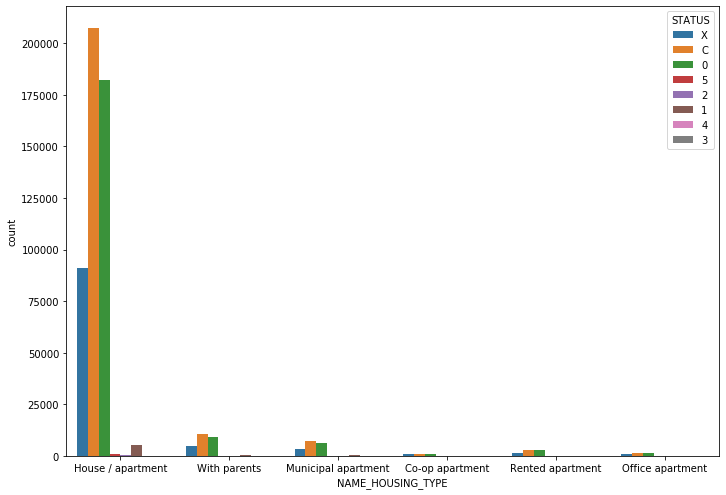

In [33]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x='NAME_HOUSING_TYPE',hue='STATUS',data=df_train)

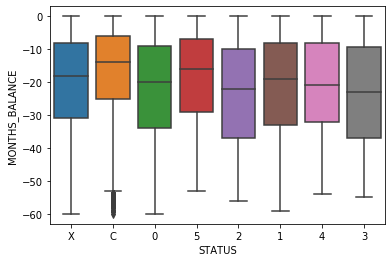

In [28]:
sns.boxplot(x='STATUS', y='MONTHS_BALANCE',data=df_train)

In [34]:
df_train.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE',
       'STATUS'],
      dtype='object')

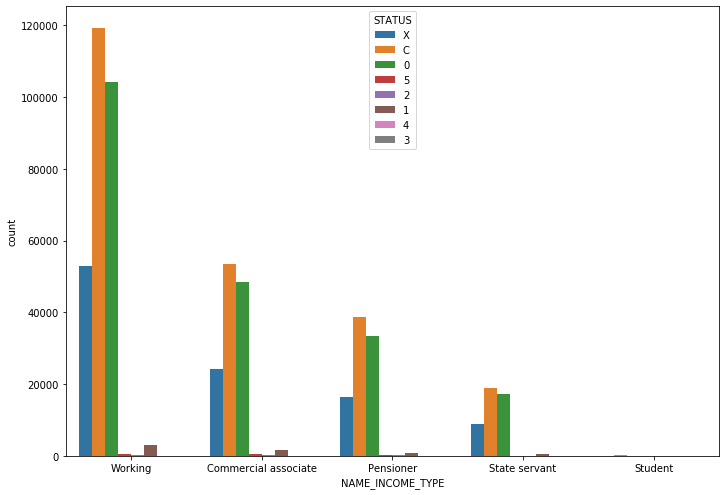

In [35]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(ax=ax,x='NAME_INCOME_TYPE',hue='STATUS',data=df_train)

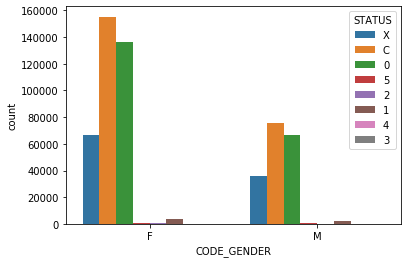

In [55]:
sns.countplot(x='CODE_GENDER',hue='STATUS',data=df_train)

# Data Cleaning and Preprocessing

In [14]:
x_train.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE'],
      dtype='object')

In [15]:
for i in x_train.columns:
    print(i,x_train[i].dtypes,x_train[i].nunique())

ID int64 36244
CODE_GENDER object 2
FLAG_OWN_CAR object 2
FLAG_OWN_REALTY object 2
CNT_CHILDREN int64 9
AMT_INCOME_TOTAL float64 265
NAME_INCOME_TYPE object 5
NAME_EDUCATION_TYPE object 5
NAME_FAMILY_STATUS object 5
NAME_HOUSING_TYPE object 6
DAYS_BIRTH int64 7168
DAYS_EMPLOYED int64 3638
FLAG_MOBIL int64 1
FLAG_WORK_PHONE int64 2
FLAG_PHONE int64 2
FLAG_EMAIL int64 2
OCCUPATION_TYPE object 18
CNT_FAM_MEMBERS float64 10
MONTHS_BALANCE int64 61


In [17]:
x_train.isnull().sum()

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        167930
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
dtype: int64

In [ ]:
# Cleaning Notes:
# drop: ID 
# impute the null records of OCCUPATION_TYPE to most frequent used value
# Change DAYS_BIRTH and DAYS_EMPLOYED to AGE and YEARS_OF_EMPLOYEMENT respectively
# DAYS_EMPLOYED=365243 means the person is unemployed, convert it to 0
# Make dummy of all the object columns, integer columns to be left alone

In [9]:
x_train.drop(['ID'],inplace=True,axis=1)
x_test.drop(['ID'],inplace=True,axis=1)

In [59]:
x_train.shape

(544400, 18)

In [60]:
544400-167930 #if we drop the Occupation_Type null values then we will lose a huge amount of data

376470

In [18]:
x_train['OCCUPATION_TYPE'].value_counts() #since Laborers is the frequent valued row we will impute the null value to the 
                                          # most frequent one

Laborers                 92163
Core staff               53902
Sales staff              49354
Managers                 47437
Drivers                  33364
High skill tech staff    22174
Accountants              19016
Medicine staff           18734
Cooking staff             9410
Security staff            8696
Cleaning staff            7955
Private service staff     4743
Low-skill Laborers        2506
Secretaries               2230
Waiters/barmen staff      1810
HR staff                  1179
IT staff                   913
Realty agents              884
Name: OCCUPATION_TYPE, dtype: int64

In [10]:
x_train = x_train.fillna(x_train['OCCUPATION_TYPE'].value_counts().index[0])

In [11]:
# replacing Days_Employed=365243 to 0 as it means that the individual is unemployed
x_train['DAYS_EMPLOYED']=x_train['DAYS_EMPLOYED'].replace(365243,0)

In [21]:
x_train[x_train['DAYS_EMPLOYED'] == 0].index

Int64Index([186377,  97559,  14679, 151556, 264965, 545579, 142501, 426816,
            148535, 262561,
            ...
            130091, 369137, 176643, 716337, 148209, 294103, 513300, 167302,
            413825, 491755],
           dtype='int64', length=89453)

In [12]:
x_train[x_train['DAYS_EMPLOYED'] == 365243].index

Int64Index([], dtype='int64')

In [13]:
# removing the - sign
x_train['DAYS_BIRTH']=-x_train['DAYS_BIRTH']

x_train['AGE']=x_train['DAYS_BIRTH']/365

In [24]:
x_train['DAYS_BIRTH'].sample(5)

716874     9052
216905    22044
422420    19657
443669    12790
600220    14677
Name: DAYS_BIRTH, dtype: int64

In [14]:
# removing the - sign
x_train['DAYS_EMPLOYED']=-x_train['DAYS_EMPLOYED']

x_train['YEARS_OF_EMPLOYEMENT']=x_train['DAYS_EMPLOYED']/365

In [15]:
x_train.drop(['DAYS_EMPLOYED','DAYS_BIRTH'],inplace=True,axis=1)

In [27]:
x_train.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'AGE', 'YEARS_OF_EMPLOYEMENT'],
      dtype='object')

In [16]:
objectcol=[]
for i in x_train.columns:
    if(x_train[i].dtypes=='object'):
        objectcol.append(i)
print(objectcol)

['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [17]:
for i in objectcol:
    dummy=pd.get_dummies(x_train[i],drop_first=True,prefix=i)
    x_train=pd.concat([x_train,dummy],axis=1)
    del x_train[i]
del dummy

In [30]:
x_train.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'AGE',
       'YEARS_OF_EMPLOYEMENT', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y',
       'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_

In [31]:
x_train.shape

(544400, 47)

# Cleaning and Preprocessing of test data

In [18]:
x_test = x_test.fillna(x_test['OCCUPATION_TYPE'].value_counts().index[0])

In [19]:
x_test['DAYS_BIRTH']=-x_test['DAYS_BIRTH']

x_test['AGE']=x_test['DAYS_BIRTH']/365

In [20]:
x_test['DAYS_EMPLOYED']=-x_test['DAYS_EMPLOYED']

x_test['YEARS_OF_EMPLOYEMENT']=x_test['DAYS_EMPLOYED']/365

In [21]:
x_test.drop(['DAYS_EMPLOYED','DAYS_BIRTH'],inplace=True,axis=1)

In [22]:
objectcoltest=[]
for i in x_test.columns:
    if(x_test[i].dtypes=='object'):
        objectcoltest.append(i)
print(objectcoltest)

['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


In [23]:
for i in objectcoltest:
    dummy=pd.get_dummies(x_test[i],drop_first=True,prefix=i)
    x_test=pd.concat([x_test,dummy],axis=1)
    del x_test[i]
del dummy

# Feature Engineering

### Correlation

In [38]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [39]:
corr_features = correlation(df_train, 0.7)
print('Len=',len(set(corr_features)),'\nCorr_features=',corr_features)

Len= 1 
Corr_features= {'CNT_FAM_MEMBERS'}


In [ ]:
# not removing because its just one column

# Modelling

In [24]:
# no matter what the score is from 1 to 5 it is 'Bad debt'
# C = paid off that month, X = no loan = 'Good debt'
map_status = {'C' : 1,
              'X' : 1,
              '0' : 1,
              '1' : 0,
              '2' : 0,
              '3' : 0,
              '4' : 0,
              '5' : 0}
y_train = y_train.map(map_status)
y_test = y_test.map(map_status)

# Logistic Regression

In [25]:
lr=LogisticRegression(class_weight='balanced')
lr.fit(x_train,y_train)

LogisticRegression(class_weight='balanced')

In [26]:
predicted_probs=lr.predict_proba(x_test)[:,1]

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,predicted_probs)  

0.5180350775731655

# Decision Tree

In [28]:
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [29]:
predicted_probs_dt=dt.predict_proba(x_test)[:,1]

In [30]:
roc_auc_score(y_test,predicted_probs_dt)

0.6378540415793486

# Random Forest

In [31]:
rf=RandomForestClassifier(class_weight='balanced')

rf.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced')

In [32]:
predicted_probs_rf=rf.predict_proba(x_test)[:,1]

In [33]:
roc_auc_score(y_test,predicted_probs_rf)

0.7857928262891589

# XGBoost

In [50]:
xgb=XGBClassifier()
xgb.fit(x_train,y_train)

XGBClassifier()

In [51]:
predicted_probs_xgb=xgb.predict_proba(x_test)[:,1]

In [52]:
roc_auc_score(y_test,predicted_probs_xgb)

0.673530328267712

In [ ]:
# Since XGB is performing worse than Random Forest we will discard this model

## We have chosen Random Forest Classifier as the best model for this dataset.